This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Advanced deep learning for computer vision

## Three essential computer vision tasks

Image classification—Where the goal is to assign one or more labels to an image. It may be either single-label classification (an image can only be in one category, excluding the others), or multi-label classification (tagging all categories that an image belongs to, as seen in figure 9.1). For example, when you search for a keyword on the Google Photos app, behind the scenes you’re querying a very large multilabel classification model—one with over 20,000 different classes, trained on millions of images.

Image segmentation—Where the goal is to “segment” or “partition” an image into different areas, with each area usually representing a category (as seen in figure 9.1). For instance, when Zoom or Google Meet diplays a custom background behind you in a video call, it’s using an image segmentation model to tell your face apart from what’s behind it, at pixel precision.

Object detection—Where the goal is to draw rectangles (called bounding boxes) around objects of interest in an image, and associate each rectangle with a class. A self-driving car could use an object-detection model to monitor cars, pedestrians, and signs in view of its cameras, for insta

Deep learning for computer vision also encompasses a number of somewhat more niche tasks besides these three, such as image similarity scoring (estimating how visually similar two images are), keypoint detection (pinpointing attributes of interest in an image, such as facial features), pose estimation, 3D mesh estimation, and so on. But to start with, image classification, image segmentation, and object detection form the foundation that every machine learning engineer should be familiar with. Most computer vision applications boil down to one of these three.nce.

Note that we won’t cover object detection, because it would be too specialized and too complicated for an introductory book. However, you can check out the RetinaNet example on keras.io, which shows how to build and train an object detection model from scratch in Keras in around 450 lines of code (https://keras.io/examples/vision/retinanet/).

Code below for managing memory on the GPU

In [14]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
       tf.config.experimental.set_memory_growth(gpu,True)

In [2]:
%env TF_GPU_ALLOCATOR=cuda_malloc_async

env: TF_GPU_ALLOCATOR=cuda_malloc_async


In [3]:
import gc

## An image segmentation example

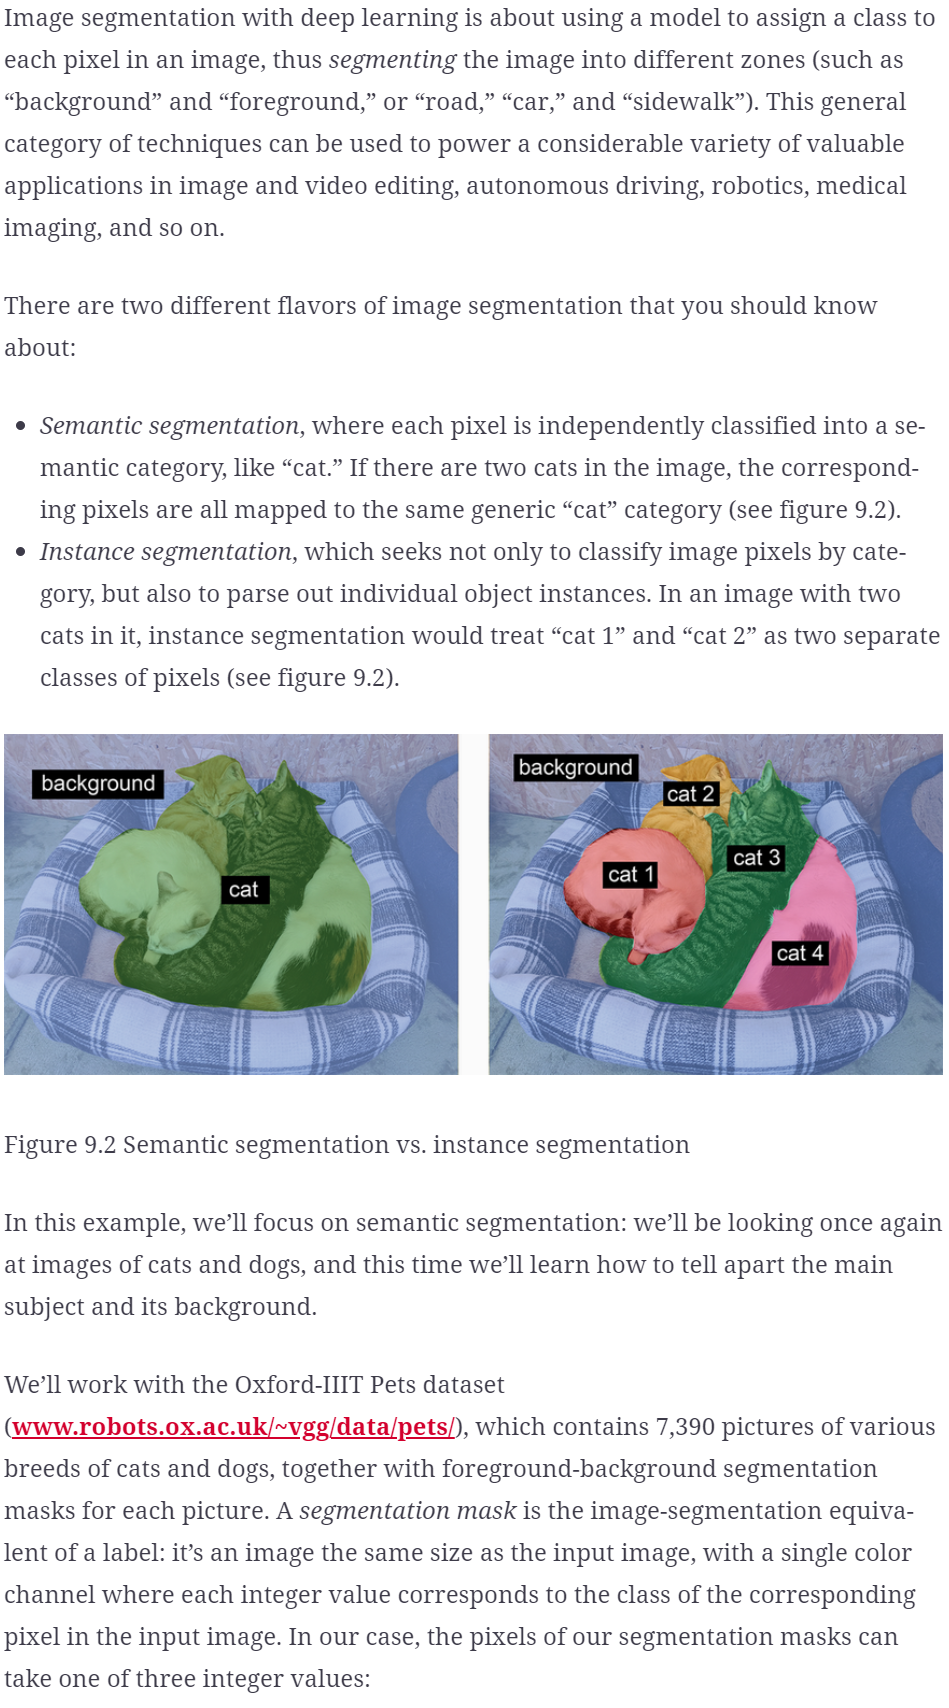
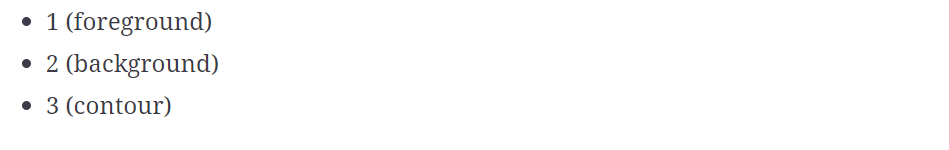

Code below is used to download image dataset

!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz

!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

!tar -xf images.tar.gz

!tar -xf annotations.tar.gz

The input pictures are stored as JPG files in the images/ folder (such as images/Abyssinian_1.jpg), and the corresponding segmentation mask is stored as a PNG file with the same name in the annotations/trimaps/ folder (such as annotations/trimaps/ Abyssinian_1.png).

Let’s prepare the list of input file paths, as well as the list of the corresponding mask file path

### Note, I deleted a lot of the images to speed processing.  This decreases accuracy, but makes the run times manageable.  If you do the same, make sure you delete the same images and masks.s:

In [4]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

Plot one of the images

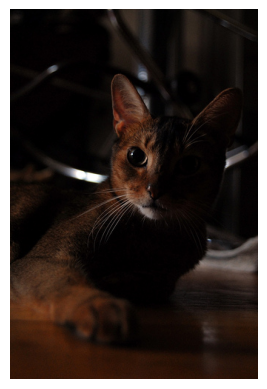

In [5]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))

Here is the corresponding target

❶ The original labels are 1, 2, and 3. We subtract 1 so that the labels range from 0 to 2, and then we multiply by 127 so that the labels become 0 (black), 127 (gray), 254 (near-white).

❷ We use color_mode="grayscale" so that the image we load is treated as having a single color channel.

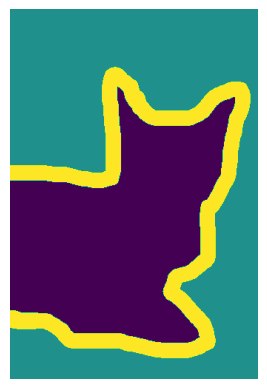

In [6]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

Next, let’s load our inputs and targets into two NumPy arrays, and let’s split the arrays into a training and a validation set. Since the dataset is very small, we can just load everything into memory:

❶ We resize everything to 200 × 200.

❷ Total number of samples in the data

❸ Shuffle the file paths (they were originally sorted by breed). We use the same seed (1337) in both statements to ensure that the input paths and target paths stay in the same order.

❹ Subtract 1 so that our labels become 0, 1, and 2.

❺ Load all images in the input_imgs float32 array and their masks in the targets uint8 array (same order). The inputs have three channels (RBG values) and the targets have a single channel (which contains integer labels).

❻ Reserve 1,000 samples for validation.

❼ Split the data into a training and a validation set.

In [7]:
import numpy as np
import random

img_size = (200, 200)  # resize to 200x200
num_imgs = len(input_img_paths)  # number of sample images

random.Random(1337).shuffle(input_img_paths)  # shuffle the file paths since they were sorted by breed
random.Random(1337).shuffle(target_paths)  # shuffle the file paths since they were sorted by breed.  Use same seed to ensure they are shuffled the same

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1  # Subtract 1 so that our labels become 0, 1, and 2.
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")  # Load all images in the input_imgs float32 array and their masks in the targets uint8 array (same order). The inputs have three channels (RBG values) and the targets have a single channel (which contains integer labels).
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000  # Reserve 1,000 samples for validation.
train_input_imgs = input_imgs[:-num_val_samples]  # Split the data into a training and a validation set.
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

❶ Don’t forget to rescale input images to the [0-1] range.

❷ Note how we use padding="same" everywhere to avoid the influence of border padding on feature map size.

❸ We end the model with a per-pixel three-way softmax to classify each output pixel into one of our three categories.

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)  # rescale to 0-1 range

    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)  # Note how we use padding="same" everywhere to avoid the influence of border padding on feature map size.
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)  # 64 kernels, 3x3 pixel kernels, stride 1 for this layer
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)  # 256 kernels, 3x3 each, stride 1
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)  # stride one for this layer
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)  # We end the model with a per-pixel three-way softmax to classify each output pixel into one of our three categories

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

The first half of the model closely resembles the kind of convnet you’d use for image classification: a stack of Conv2D layers, with gradually increasing filter sizes. We downsample our images three times by a factor of two each, ending up with activations of size (25, 25, 256). The purpose of this first half is to encode the images into smaller feature maps, where each spatial location (or pixel) contains information about a large spatial chunk of the original image. You can understand it as a kind of compression.

One important difference between the first half of this model and the classification models you’ve seen before is the way we do downsampling: in the classification convnets from the last chapter, we used MaxPooling2D layers to downsample feature maps. Here, we downsample by adding strides to every other convolution layer

We do this because, in the case of image segmentation, we care a lot about the spatial location of information in the image, since we need to produce per-pixel target masks as output of the model. When you do 2 × 2 max pooling, you are completely destroying location information within each pooling window: you return one scalar value per window, with zero knowledge of which of the four locations in the windows the value came from. So while max pooling layers perform well for classification tasks, they would hurt us quite a bit for a segmentation task. Meanwhile, strided convolutions do a better job at downsampling feature maps while retaining location information. Throughout this book, you’ll notice that we tend to use strides instead of max pooling in any model that cares about feature location, such as the generative models in chapter 12.

The second half of the model is a stack of Conv2DTranspose layers. What are those? Well, the output of the first half of the model is a feature map of shape (25, 25, 256), but we want our final output to have the same shape as the target masks, (200, 200, 3). Therefore, we need to apply a kind of inverse of the transformations we’ve applied so far—something that will upsample the feature maps instead of downsampling them. That’s the purpose of the Conv2DTranspose layer: you can think of it as a kind of convolution layer that learns to upsample. If you have an input of shape (100, 100, 64), and you run it through the layer Conv2D(128, 3, strides=2, padding="same"), you get an output of shape (50, 50, 128). If you run this output through the layer Conv2DTranspose(64, 3, strides=2, padding="same"), you get back an output of shape (100, 100, 64), the same as the original. So after compressing our inputs into feature maps of shape (25, 25, 256) via a stack of Conv2D layers, we can simply apply the corresponding sequence of Conv2DTranspose layers to get back to images of shape (200, 200, 3).

https://towardsdatascience.com/understand-transposed-convolutions-and-build-your-own-transposed-convolution-layer-from-scratch-4f5d97b2967
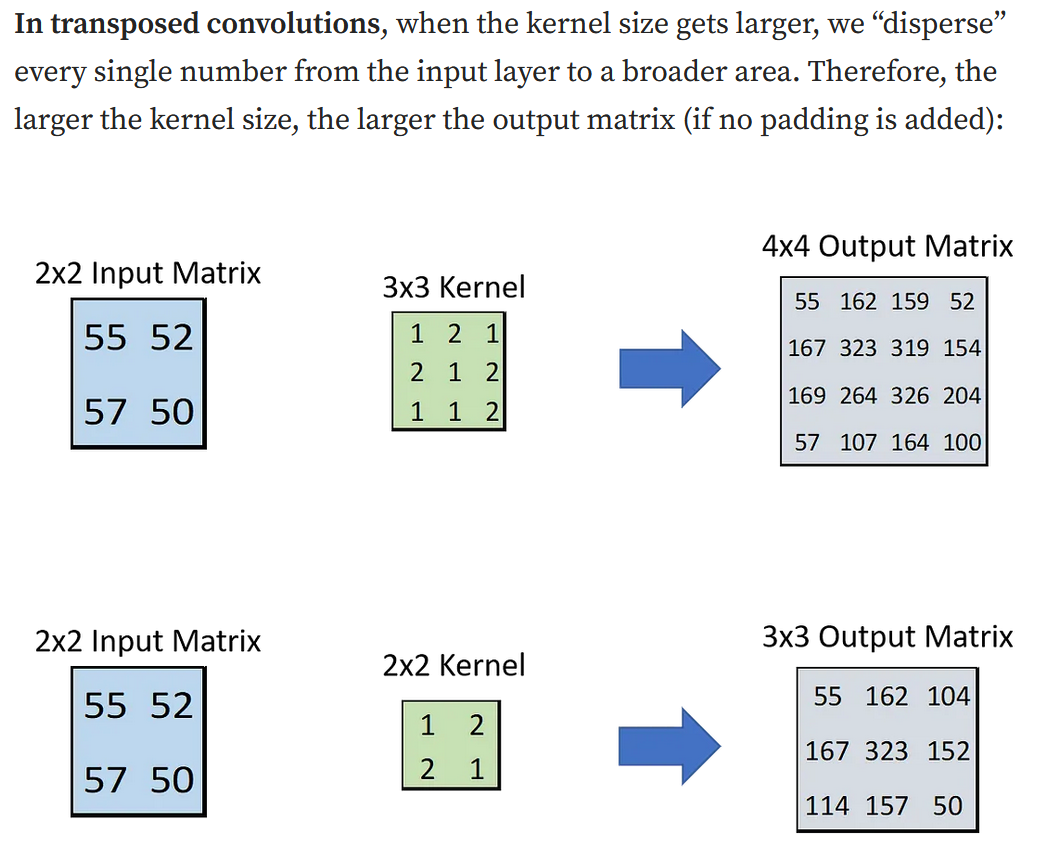

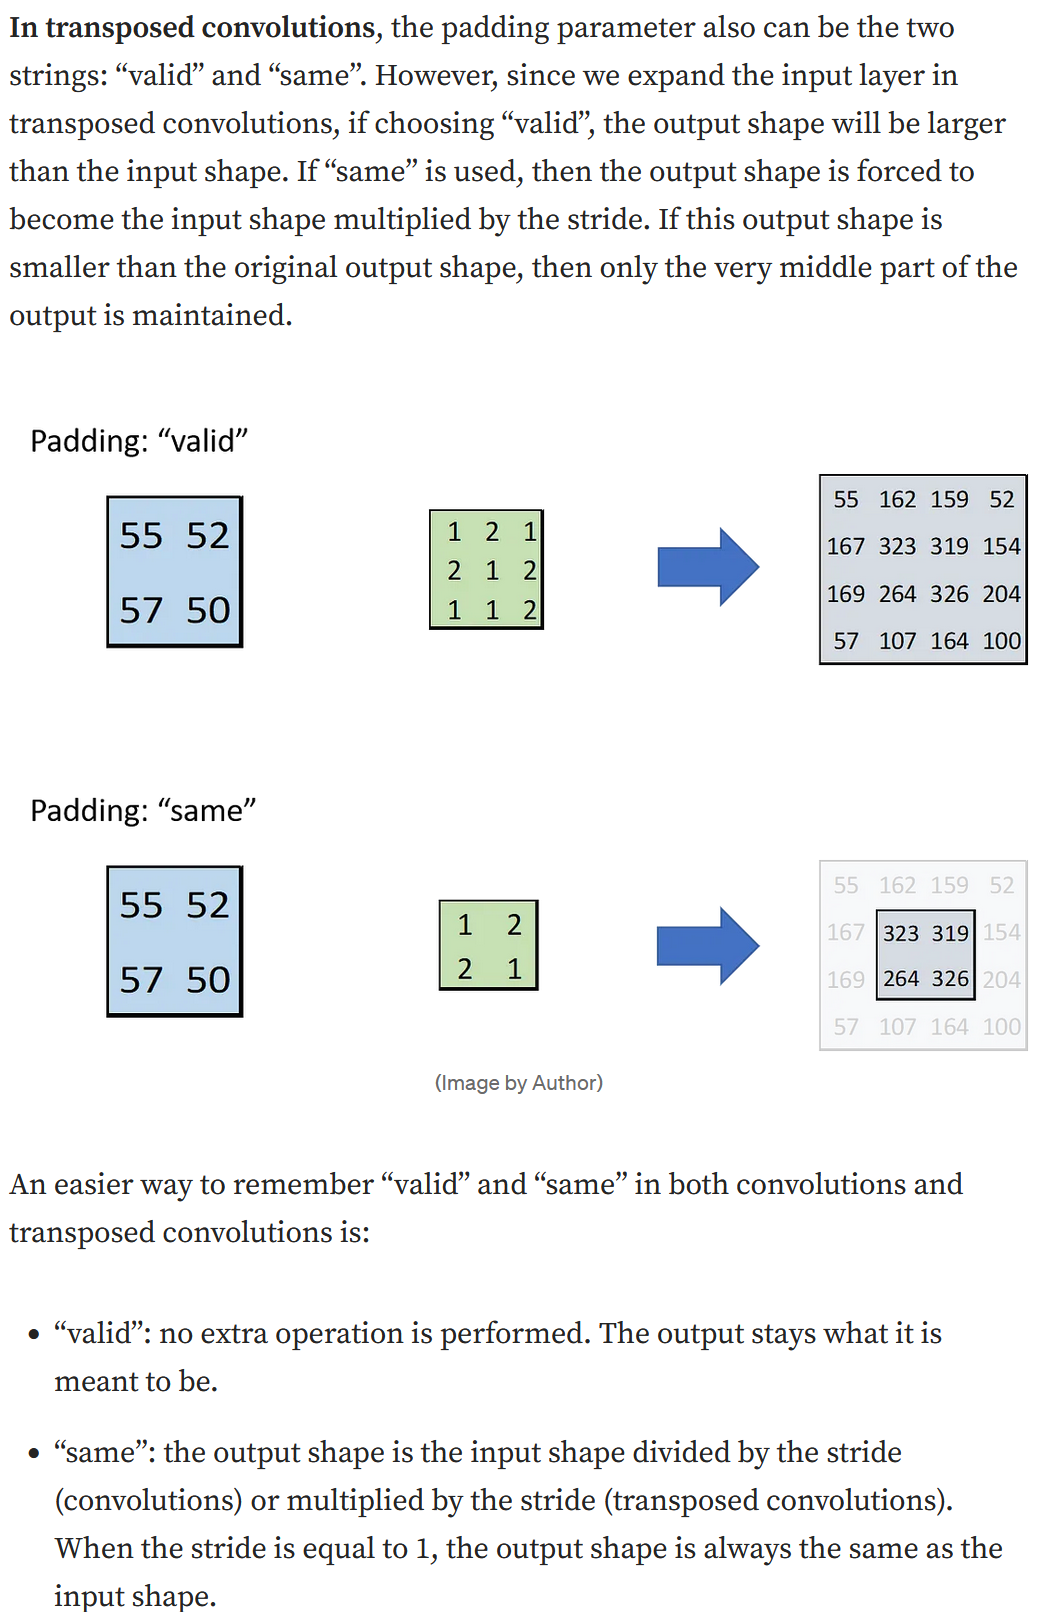

In [10]:
tf.keras.backend.clear_session()
gc.collect()
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
                                    save_best_only=True)
]

history = model.fit(train_input_imgs, train_targets,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=16,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/50
89/89 [==============================] - ETA: 0s - loss: 0.9443

2024-03-18 16:13:58.785862: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 2351964176 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 21338523/4294705152
2024-03-18 16:13:58.785909: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      2365954459
InUse:                      2120240232
MaxInUse:                   5356056692
NumAllocs:                       26326
MaxAllocSize:               2965897216
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-03-18 16:13:58.785926: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-03-18 16:13:58.785930: E external/local_xla/xla/stream_executor/g

89/89 [==============================] - 85s 694ms/step - loss: 0.9443 - val_loss: 0.9673
Epoch 2/50
89/89 [==============================] - 37s 415ms/step - loss: 0.9266 - val_loss: 0.8844
Epoch 3/50
89/89 [==============================] - 35s 390ms/step - loss: 0.8827 - val_loss: 0.8490
Epoch 4/50
89/89 [==============================] - 34s 383ms/step - loss: 0.8345 - val_loss: 0.8323
Epoch 5/50
89/89 [==============================] - 34s 383ms/step - loss: 0.8143 - val_loss: 0.7914
Epoch 6/50
89/89 [==============================] - 35s 392ms/step - loss: 0.7845 - val_loss: 0.7882
Epoch 7/50
89/89 [==============================] - 34s 388ms/step - loss: 0.7900 - val_loss: 0.7843
Epoch 8/50
89/89 [==============================] - 35s 391ms/step - loss: 0.7667 - val_loss: 0.7250
Epoch 9/50
89/89 [==============================] - 40s 446ms/step - loss: 0.7638 - val_loss: 0.7387
Epoch 10/50
89/89 [==============================] - 38s 425ms/step - loss: 0.7441 - val_loss: 0.7553


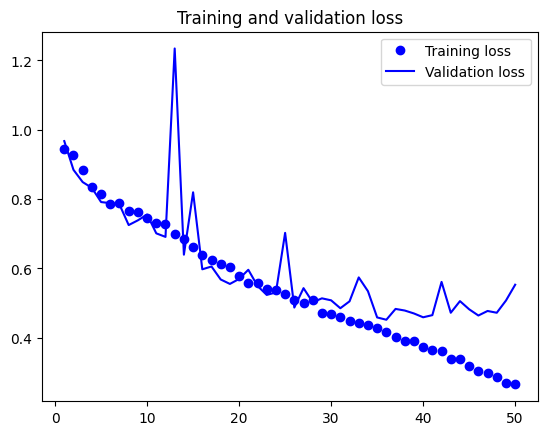

In [11]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

You can see that we start overfitting midway, around epoch 40. Let’s reload our best performing model according to the validation loss, and demonstrate how to use it to predict a segmentation mask

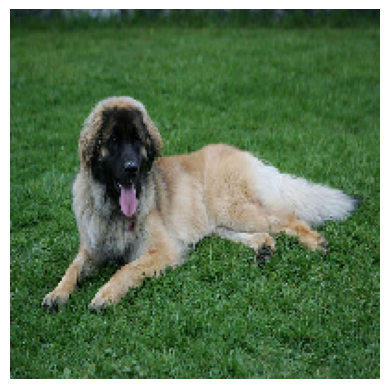

2024-03-18 16:44:32.101971: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 2312504336 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 1095080347/4294705152
2024-03-18 16:44:32.102022: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      2365954459
InUse:                       823637424
MaxInUse:                   5356056692
NumAllocs:                     1056010
MaxAllocSize:               2965897216
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-03-18 16:44:32.102042: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-03-18 16:44:32.102046: E external/local_xla/xla/stream_executor

1/1 [==============================] - 3s 3s/step


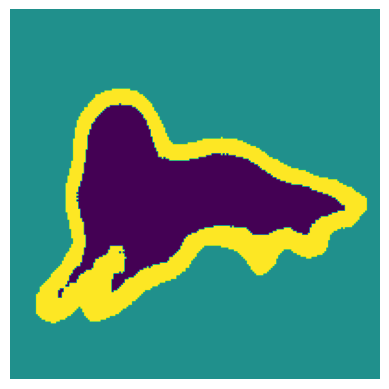

In [12]:
from tensorflow.keras.utils import array_to_img
tf.keras.backend.clear_session()
gc.collect()

model = keras.models.load_model("oxford_segmentation.keras")

i = 3
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))
plt.show()

mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)
    plt.show()

display_mask(mask)

There are a couple of small artifacts in our predicted mask, caused by geometric shapes in the foreground and background. Nevertheless, our model appears to work nicely.

By this point, throughout chapter 8 and the beginning of chapter 9, you’ve learned the basics of how to perform image classification and image segmentation: you can already accomplish a lot with what you know. However, the convnets that experienced engineers develop to solve real-world problems aren’t quite as simple as those we’ve been using in our demonstrations so far. You’re still lacking the essential mental models and thought processes that enable experts to make quick and accurate decisions about how to put together state-of-the-art models. To bridge that gap, you need to learn about architecture patterns. 